# Introduction

Today, internet and social media have become the fastest and easiest ways to get information. In this age, reviews, opinions, feedbacks, messages and recommendations have become significant source of information. Thanks to advancement in technologies, we are now able to extract meaningful information from such data using various Natural Language Processing (NLP) techniques. NLP , a branch of Artificial Intelligence (AI), makes use of computers and human natural language to output valuable information. NLP is commonly used in text classification task such as spam detection and sentiment analysis, text generation, language translations and document classification.

To understand how we can use TensorFlow2 to build SMS spam detection model. Particularly, we will build a binary classification model to detect whether a text message is spam or not (aka Ham). Moreover, we’ll learn how to implement Dense, Long Short Term Memory (LSTM)  deep learning models in TensorFlow2 Keras API

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle 
import re
import string
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN,Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential

In [2]:
#select GPU working %
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

# Read raw dataset

In [3]:
# we also use seperater to bulit a proper dataframe
messages = pd.read_csv("SMSSpamCollection", sep ='\t', names= ["label","message"])
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
messages.shape

(5572, 2)

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
messages.isnull().sum()

label      0
message    0
dtype: int64

In [8]:
messages.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

We have imbalanced dataset

In [9]:
#find duplicats value
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow)

     label                                            message
103    ham  As per your request 'Melle Melle (Oru Minnamin...
154    ham  As per your request 'Melle Melle (Oru Minnamin...
207    ham  As I entered my cabin my PA said, '' Happy B'd...
223    ham                             Sorry, I'll call later
326    ham                   No calls..messages..missed calls
...    ...                                                ...
5524  spam  You are awarded a SiPix Digital Camera! call 0...
5535   ham  I know you are thinkin malaria. But relax, chi...
5539   ham                         Just sleeping..and surfing
5553   ham                        Hahaha..use your brain dear
5558   ham                             Sorry, I'll call later

[403 rows x 2 columns]


looks like we have 403  duplicate messages.

In [10]:
messages.label.unique()

array(['ham', 'spam'], dtype=object)

# Visualization

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


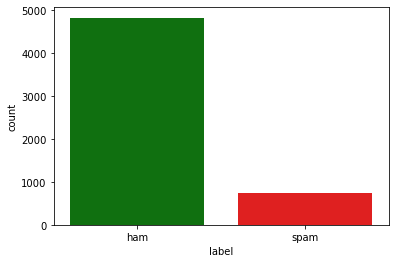

ham     4825
spam     747
Name: label, dtype: int64


In [11]:
sns.countplot(messages.label, palette = ["green", "red"])
plt.show()
print(messages.label.value_counts())

In [12]:
print(messages.message[0])
print(messages.label[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham


In [13]:
from sklearn.utils import shuffle
messages = shuffle(messages)
messages.reset_index(inplace= True)

In [14]:
messages.head(3)

,index,label,message
0,3791,ham,I love you !!! You know? Can you feel it? Does...
1,5489,ham,Oh thanks a lot..i already bought 2 eggs ..
2,3618,ham,Sorry sent blank msg again. Yup but trying 2 d...


In [15]:
messages=messages.drop("index",axis=1)

In [16]:
messages

,label,message
0,ham,I love you !!! You know? Can you feel it? Does...
1,ham,Oh thanks a lot..i already bought 2 eggs ..
2,ham,Sorry sent blank msg again. Yup but trying 2 d...
3,ham,"Sorry, was in the bathroom, sup"
4,spam,URGENT! We are trying to contact U. Todays dra...
...,...,...
5567,ham,Think you sent the text to the home phone. Tha...
5568,ham,SORRY IM STIL FUCKED AFTER LAST NITE WENT TOBE...
5569,ham,Looks like u wil b getting a headstart im leav...
5570,ham,Am i that much dirty fellow?


In [17]:
messages = messages.drop_duplicates()

In [18]:
messages.shape

(5169, 2)

In [19]:
messages.label.value_counts()

ham     4516
spam     653
Name: label, dtype: int64

In [20]:
messages['length'] = messages['message'].apply(len)
messages.head()

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,label,message,length
0,ham,I love you !!! You know? Can you feel it? Does...,157
1,ham,Oh thanks a lot..i already bought 2 eggs ..,43
2,ham,Sorry sent blank msg again. Yup but trying 2 d...,74
3,ham,"Sorry, was in the bathroom, sup",31
4,spam,URGENT! We are trying to contact U. Todays dra...,157


In [21]:
messages.length.max()

910

Balance the data

In [22]:
X = messages.message
y = messages.label

In [23]:
print(X[0])
print(y[0])

I love you !!! You know? Can you feel it? Does it make your belly warm? I wish it does, my love ... I shall meet you in your dreams, Ahmad ... *adoring kiss*
ham


In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(y)


In [27]:
train_y[0:5]

array([0, 0, 0, 0, 1])

In [28]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

review_lines = list()
lines = X.values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    words = [wn.lemmatize(w) for w in words if w not in stopwords]
    review_lines.append(words)

In [29]:
len(review_lines)

5169

In [30]:
X[0:2]

0    I love you !!! You know? Can you feel it? Does...
1          Oh thanks a lot..i already bought 2 eggs ..
Name: message, dtype: object

In [31]:
review_lines

[['love',
  'know',
  'feel',
  'make',
  'belly',
  'warm',
  'wish',
  'love',
  'shall',
  'meet',
  'dream',
  'ahmad',
  'adoring',
  'kiss'],
 ['oh', 'thanks', 'lot', 'already', 'bought', 'egg'],
 ['sorry', 'sent', 'blank', 'msg', 'yup', 'trying', 'serious', 'studying'],
 ['sorry', 'bathroom', 'sup'],
 ['urgent',
  'trying',
  'contact',
  'u',
  'today',
  'draw',
  'show',
  'prize',
  'guaranteed',
  'call',
  'land',
  'line',
  'claim',
  'valid'],
 ['half', 'year', 'missed', 'friendship'],
 ['know',
  'wot',
  'people',
  'wear',
  'shirt',
  'jumper',
  'hat',
  'belt',
  'know',
  'r',
  'cribbs'],
 ['back',
  'bit',
  'long',
  'co',
  'accident',
  'divert',
  'via',
  'wadebridgei',
  'brilliant',
  'weekend',
  'thanks',
  'speak',
  'soon',
  'lot',
  'love'],
 ['ill', 'get', 'tomorrow', 'send'],
 ['ü', 'pay', 'first', 'lar', 'da', 'stock', 'comin'],
 ['unfortunately',
  'found',
  'pick',
  'sister',
  'airport',
  'evening',
  'nt',
  'think',
  'going',
  'try',
 

In [32]:
X = review_lines

In [33]:
### Save processed data

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(train_y,pickle_out)
pickle_out.close()



In [35]:
#load
X = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

In [36]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
import gensim

#train word2vec model
model = gensim.models.Word2Vec(sentences = X, vector_size = 200, window = 5, workers = 4,min_count =1 )



In [62]:
model.wv.most_similar("horrible")

[('urgent', 0.9636005163192749),
 ('month', 0.9635542035102844),
 ('half', 0.9634506702423096),
 ('start', 0.9634400010108948),
 ('name', 0.9634183049201965),
 ('word', 0.9633923768997192),
 ('live', 0.9633676409721375),
 ('landline', 0.9633322358131409),
 ('gift', 0.9632734656333923),
 ('ticket', 0.9632647037506104)]

In [63]:
#save embedding model
filename = "spam_embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary = False)

In [64]:
import os

embeddings_index = {}
f = open(os.path.join('', 'spam_embedding_word2vec.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype ='float32')
    embeddings_index[word] = coefs
f.close()

In [65]:
#vectorize the text samples into a 2D ineger tensor 
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)
sequences = tokenizer_obj.texts_to_sequences(X)



#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen = 2100)
print('Shape of review tensor:', review_pad.shape)


Found 7206 unique tokens.
Shape of review tensor: (5169, 2100)


In [66]:
review_pad[0]# data

array([   0,    0,    0, ..., 1105, 2170,  225])

In [67]:
print('shape of label tensor:', y.shape)

shape of label tensor: (5169,)


In [68]:
y[0]#label

0

In [69]:
EMBEDDING_DIM = 200

num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [70]:
print(num_words)

7207


In [71]:
#split our data
Validation_split = 0.01

indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = y[indices]
num_validation_samples = int(Validation_split * review_pad.shape[0])

x_train = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
x_val = review_pad[-num_validation_samples:]
y_val = sentiment[-num_validation_samples:]

In [72]:
print('Shape of x_train tensor:', x_train.shape)
print('Shape of y_train tensor:', y_train.shape)
print('Shape of x_val tensor:', x_val.shape)
print('Shape of y_val tensor:', y_val.shape)

Shape of x_train tensor: (5118, 2100)
Shape of y_train tensor: (5118,)
Shape of x_val tensor: (51, 2100)
Shape of y_val tensor: (51,)


In [73]:
x_train[0]

array([   0,    0,    0, ...,  685,  220, 3985])

In [74]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [75]:
idx = tokenizer_obj.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [76]:
print(return_to_sentence(x_train[1]))

know week going tirunelvai da


In [77]:
y_train[1]

0

In [84]:
#model built
model = Sequential()
embedding_layer = Embedding(num_words,200,weights = [embedding_matrix], 
                            trainable = False )

model.add(embedding_layer)
model.add(LSTM(units =30, return_sequences= True))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(10,return_sequences = True))

model.add(LSTM(5))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = "binary_crossentropy",optimizer ="rmsprop",metrics=["accuracy"])

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         1441400   
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 30)          27720     
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 20)          4080      
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 10)          1240      
_________________________________________________________________
lstm_16 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 1,474,766
Trainable params: 33,366
Non-trainable params: 1,441,400
_______________________________________

In [86]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 10, validation_data = (x_val, y_val),shuffle=True, verbose = 1)

Epoch 1/10
40/40 [==============================] - 26s 545ms/step - loss: 0.5061 - accuracy: 0.8066 - val_loss: 0.3244 - val_accuracy: 0.9020
Epoch 2/10
40/40 [==============================] - 21s 522ms/step - loss: 0.3667 - accuracy: 0.8665 - val_loss: 0.2672 - val_accuracy: 0.9020
Epoch 3/10
40/40 [==============================] - 23s 577ms/step - loss: 0.3187 - accuracy: 0.8713 - val_loss: 0.2509 - val_accuracy: 0.9020
Epoch 4/10
40/40 [==============================] - 24s 595ms/step - loss: 0.3128 - accuracy: 0.8725 - val_loss: 0.2382 - val_accuracy: 0.9020
Epoch 5/10
40/40 [==============================] - 24s 615ms/step - loss: 0.2977 - accuracy: 0.8755 - val_loss: 0.2398 - val_accuracy: 0.9020
Epoch 6/10
40/40 [==============================] - 26s 641ms/step - loss: 0.2925 - accuracy: 0.8766 - val_loss: 0.2354 - val_accuracy: 0.9020
Epoch 7/10
40/40 [==============================] - 26s 646ms/step - loss: 0.3107 - accuracy: 0.8687 - val_loss: 0.2349 - val_accuracy: 0.9020

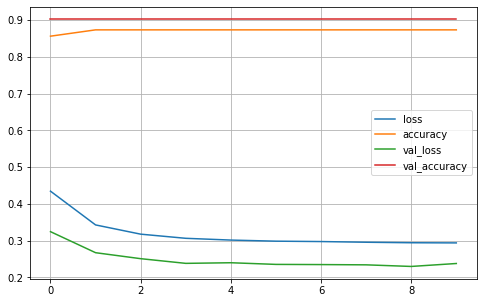

In [87]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [88]:
y_pred = model.predict_classes(x_val, batch_size = 128)

true = 0
for i, y in enumerate(y_val):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Correct Prediction: 46
Wrong Prediction: 5
Accuracy: 90.19607843137256
